In [39]:
# -----------------------------------------
# Data Processing Libraries
# -----------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -----------------------------------------
# Machine Learning Models
# -----------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb

# -----------------------------------------
# Resampling Techniques for Imbalanced Data
# -----------------------------------------
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# -----------------------------------------
# Hyperparameter Tuning
# -----------------------------------------
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# -----------------------------------------
# Evaluation Metrics
# -----------------------------------------
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
    classification_report,
    roc_auc_score
)

# -----------------------------------------
# Visualization Tools
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image

# -----------------------------------------
# Utilities
# -----------------------------------------
from collections import Counter
import collections


#### Import preprocessed data without missing values, removed outliers

In [41]:

train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')



In [52]:
# Define the target variable (e.g., 'target') and features (all other columns)
X_train = train.drop('readmitted', axis=1)  # Drop the target column for features
y_train = train['readmitted']  # Select the target column

X_test = test.drop('readmitted', axis=1)  # Same for test set
y_test = test['readmitted']
X_train.shape

(80192, 113)

#### Standard Decision Tree (Baseline model)

In [44]:
# Initialize the Decision Tree model
dt_classifier = DecisionTreeClassifier(
    max_depth=10,              # Limit tree depth to avoid overfitting
    min_samples_split=10,      # Require at least 10 samples to split a node
    min_samples_leaf=5,        # Require at least 5 samples per leaf
    criterion='gini',          # Use Gini impurity for splitting
    class_weight='balanced',   # Handle class imbalance
    random_state=42            # Fix randomness for reproducibility
)

# Train the Decision Tree model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
acc_dt = accuracy_score(y_test, y_pred)
print("Standard Decision Tree - Test Accuracy:", round(acc_dt, 2))
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred)))

Standard Decision Tree - Test Accuracy: 0.66
Accuracy is 0.66
Precision is 0.17
Recall is 0.55
F1 score is 0.26


#### Standard Bagging classifier



In [49]:

# Create a bagging classifier 
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10,class_weight='balanced'),  # Example base estimator with a max depth of 5
    n_estimators=50,  # Number of base estimators (trees)
    max_samples=0.8,  # Fraction of samples to use for each base estimator
    max_features=0.8,  # Fraction of features to use for each base estimator
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
      # Ensuring reproducibility
)

# Train the bagging classifier on the training data
bagging_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_clf.predict(X_test)

# Calculate the accuracy of the model
acc_bag = accuracy_score(y_test, y_pred)
print("Bagging Classifier - Test Accuracy:", round(acc_bag, 2))
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred)))

Bagging Classifier - Test Accuracy: 0.7
Accuracy is 0.70
Precision is 0.19
Recall is 0.53
F1 score is 0.28


#### Balanced Bagging Classifier

In [56]:
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),  
    n_estimators=50,  # Number of base estimators (trees)
    sampling_strategy='auto',  # Automatically balance the class distribution
    replacement=True,  # Sample with replacement for better variance
    max_samples=0.8,
    max_features=0.8,
    n_jobs=-1,
    random_state=42  # Ensuring reproducibility
)
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred)))

[[11886  5950]
 [  898  1315]]
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     17836
           1       0.18      0.59      0.28      2213

    accuracy                           0.66     20049
   macro avg       0.56      0.63      0.53     20049
weighted avg       0.85      0.66      0.72     20049

Accuracy is 0.66
Precision is 0.18
Recall is 0.59
F1 score is 0.28


#### Standard Random Forest Classifier with Class weighting

In [60]:
# Create a Random Forest Classifier with Class Weighting
rf_cw = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=10,              # Maximum tree depth
    min_samples_split=5,       # Minimum samples to split
    min_samples_leaf=2,        # Minimum samples per leaf
    max_features='sqrt',       # Features to consider at each split
    class_weight='balanced',   # Handle class imbalance
    bootstrap=True,            # Use bootstrap sampling
    oob_score=True,            # Use out-of-bag samples for validation
    n_jobs=-1,                 # Use all CPU cores
    random_state=42            # For reproducibility
)


# Train the Random Forest classifier on the training data
rf_cw.fit(X_train, y_train)

# Make predictions on the test set
y_pred_cw = rf_cw.predict(X_test)

# Calculate the accuracy of the model
acc_cw = accuracy_score(y_test, y_pred_cw)
print("Random Forest with Class Weighting Accuracy:",round(acc_cw, 2))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred_cw)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred_cw)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred_cw)))


Random Forest with Class Weighting Accuracy: 0.68
Precision is 0.19
Recall is 0.57
F1 score is 0.28


#### Evaluation of Random forest with class weighting

Only 17% of the patients flagged as high risk for readmission were actually readmitted. This suggests the model generates a high number of false positives.
Recall (0.60):

The model successfully identifies 60% of the actual readmissions, which is decent. However, missing the remaining 40% (false negatives) could still have serious implications.


In [61]:
# Evaluate the model

# Calculate and print the accuracy
acc_rus = accuracy_score(y_test, y_pred_cw)
print("Random Forest with Random Undersampling Accuracy: {:.2f}".format(acc_rus))

# Calculate precision, recall, and F1-score for binary classification (assuming labels 0 and 1)
precision = precision_score(y_test, y_pred_cw)
recall = recall_score(y_test, y_pred_cw)
f1 = f1_score(y_test, y_pred_cw)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Print the classification report for detailed metrics across all classes
report = classification_report(y_test, y_pred_cw)
print("\nClassification Report:\n", report)



Random Forest with Random Undersampling Accuracy: 0.68
Precision: 0.19
Recall: 0.57
F1 Score: 0.28

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79     17836
           1       0.19      0.57      0.28      2213

    accuracy                           0.68     20049
   macro avg       0.56      0.63      0.54     20049
weighted avg       0.85      0.68      0.73     20049



Confusion Matrix:
 [[11271  6565]
 [  883  1330]]


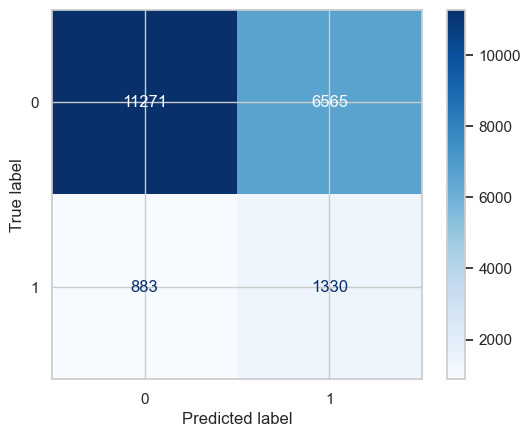

In [62]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rus)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_rus.classes_)
disp.plot(cmap='Blues')

#### XGBoost Classifier with SMOTE + ENN oversampler

First, scale continious numerical values 

In [63]:

# Identify the binary and continuous columns

# List of continuous columns that you want to scale
continuous_columns = ['age', 'time_in_hospital','num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient_log',
       'number_emergency_log', 'number_inpatient_log']

# Separate the continuous features
X_train_continuous = X_train[continuous_columns]
X_test_continuous = X_test[continuous_columns]

# Apply StandardScaler to the continuous features
scaler = StandardScaler()
X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_test_continuous_scaled = scaler.fit_transform(X_test_continuous)


# Convert the scaled features back to a DataFrame
X_train_continuous_scaled = pd.DataFrame(X_train_continuous_scaled, columns=continuous_columns)
X_test_continuous_scaled = pd.DataFrame(X_test_continuous_scaled, columns=continuous_columns)

# Concatenate the scaled continuous columns with the rest of the data
X_train_scaled = pd.concat([X_train.drop(continuous_columns, axis=1), X_train_continuous_scaled], axis=1)
X_test_scaled = pd.concat([X_test.drop(continuous_columns, axis=1), X_test_continuous_scaled], axis=1)



##### Apply SMOTEENN to training data

In [64]:

counter = collections.Counter(y_train)
print('Before', counter)
# oversampling the train dataset using SMOTE + ENN
smote = SMOTEENN()
X_train_smenn, y_train_smenn = smote.fit_resample (X_train_scaled, y_train)
counter = collections.Counter (y_train_smenn)
print('After', counter)


Before Counter({0: 71155, 1: 9037})
After Counter({1: 70875, 0: 30038})


##### XGBoost classifier

Results With Oversampling Smote + ENN
XGBoost Accuracy: 0.35
Kappa Score: 0.04
F1 Score: 0.22
Recall: 0.85
Precision: 0.13


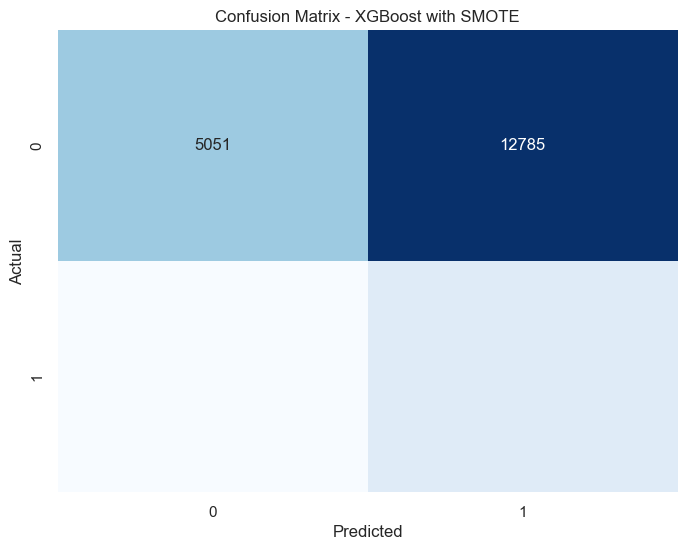

In [66]:

# Initialize and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    n_estimators=200,          # Number of boosting rounds
    max_depth=10,              # Maximum tree depth
    learning_rate=0.05,        # Learning rate
    subsample=0.8,             # Fraction of training samples per tree
    colsample_bytree=0.8,      # Fraction of features per tree
    colsample_bylevel=0.8,     # Fraction of features per level
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1,              # L2 regularization
    scale_pos_weight=1,        # Adjust for class imbalance (set based on data)
    n_jobs=-1,                 # Use all CPU cores
    random_state=42            # For reproducibility
)
xgb_classifier.fit(
    X_train_smenn, 
    y_train_smenn                  # Print training progress
)

# Make predictions using the model
y_pred = xgb_classifier.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print the evaluation metrics
print("Results With Oversampling Smote + ENN")
print("XGBoost Accuracy:", round(accuracy,2))
print("Kappa Score:", round(kappa,2))
print("F1 Score:", round(f1,2))
print("Recall:", round(recall,2))
print("Precision:", round(precision,2))

#print confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - XGBoost with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [67]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after oversampling
counter = Counter(y_train_smote)
print('Before:', Counter(y_train))
print('After SMOTE:', counter)


Before: Counter({0: 71155, 1: 9037})
After SMOTE: Counter({0: 71155, 1: 71155})


                        Feature  Importance
112        number_inpatient_log    0.055054
106              race_Caucasian    0.041414
105                  race_Asian    0.040402
35          admission_type_id_7    0.032600
6              number_diagnoses    0.030035
..                          ...         ...
14                    glyburide    0.000000
10               chlorpropamide    0.000000
20                 troglitazone    0.000000
38   discharge_disposition_id_3    0.000000
47        admission_source_id_4    0.000000

[113 rows x 2 columns]
Results With Oversampling Smote + ENN
XGBoost Accuracy: 0.5
Kappa Score: 0.06
F1 Score: 0.23
Recall: 0.67
Precision: 0.14


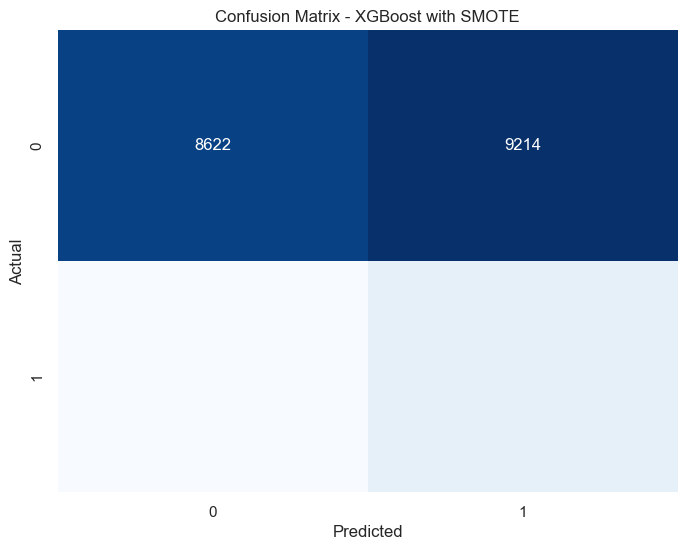

In [69]:

# Initialize and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    n_estimators=200,          # Number of boosting rounds
    max_depth=10,              # Maximum tree depth
    learning_rate=0.05,        # Learning rate
    subsample=0.8,             # Fraction of training samples per tree
    colsample_bytree=0.8,      # Fraction of features per tree
    colsample_bylevel=0.8,     # Fraction of features per level
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1,              # L2 regularization
    scale_pos_weight=1,        # Adjust for class imbalance (set based on data)
    n_jobs=-1,                 # Use all CPU cores
    random_state=42            # For reproducibility
)
xgb_classifier.fit(
    X_train_smote, 
    y_train_smote                  # Print training progress
)

# Make predictions using the model
y_pred = xgb_classifier.predict(X_test_scaled)

importance = xgb_classifier.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print the evaluation metrics
print("Results With Oversampling Smote + ENN")
print("XGBoost Accuracy:", round(accuracy,2))
print("Kappa Score:", round(kappa,2))
print("F1 Score:", round(f1,2))
print("Recall:", round(recall,2))
print("Precision:", round(precision,2))

#print confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - XGBoost with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Bayesian Optimization 

4.3.1 Initialize domain space for range of values

In [76]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

4.3.2 Define objective function

In [88]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], early_stopping_rounds=10,max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),eval_metric="auc")
    
    evaluation = [( X_train_smenn, y_train_smenn), ( X_test_scaled, y_test)]
    
    clf.fit(X_train_smenn, y_train_smenn,
            eval_set=evaluation, 
            verbose=False)
    

    pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


Optimization algorithm

In [89]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.11152675943937354                                    
SCORE:                                                                             
0.12160207491645468                                                                
SCORE:                                                                             
0.1204050077310589                                                                 
SCORE:                                                                             
0.11855952915357375                                                                
SCORE:                                                                             
0.11152675943937354                                                                
SCORE:                                                                             
0.1204050077310589                                                                 
SCORE:                                          

#### Best parameters

In [91]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5241991813284231, 'gamma': 5.848919887025276, 'max_depth': 17.0, 'min_child_weight': 6.0, 'reg_alpha': 40.0, 'reg_lambda': 0.4168453849002615}


In [99]:
best_model = xgb.XGBClassifier(
    colsample_bytree= 0.5241991813284231,
    gamma= 5.848919887025276,
    max_depth = 17,
    min_child_weight = 6.0,
    reg_alpha = 40.0,
    reg_lambda =  0.4168453849002615,
    n_estimators=200,  # Keep n_estimators to what you used in tuning
    random_state=42,
    eval_metric="auc",
    learning_rate=0.05,           # Learning rate (keep as-is unless tuned)
    subsample=0.8,
    colsample_bylevel=0.8,
    scale_pos_weight=1,           # Adjust for class imbalance (can tune further if needed)
    n_jobs=-1
)

# Fit the model to the training data
best_model.fit(X_train_smenn, y_train_smenn)

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)


In [100]:
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print the evaluation metrics
print("Results With Oversampling Smote + ENN")
print("XGBoost Accuracy:", round(accuracy,2))
print("Kappa Score:", round(kappa,2))
print("F1 Score:", round(f1,2))
print("Recall:", round(recall,2))
print("Precision:", round(precision,2))

Results With Oversampling Smote + ENN
XGBoost Accuracy: 0.31
Kappa Score: 0.03
F1 Score: 0.22
Recall: 0.88
Precision: 0.12


##### Changing threshold 